# 4. Bag Of Vectors Sentiment Analysis

## 0. Loading data

In [1]:
import os, sys, csv, time, string, unicodedata
from collections import OrderedDict
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import torchtext as tt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

First, load train/dev/test data

In [2]:
!curl -fsS https://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip -o /tmp/trainDevTestTrees_PTB.zip
!unzip -q -o -d ./data /tmp/trainDevTestTrees_PTB.zip
!rm -f /tmp/trainDevTestTrees_PTB.zip

In [3]:
def get_dataset(path):
    dataset = [[0, 0]]
    for line in open(path, 'r').readlines():
        soup = line.split()
        tokens = []
        for chunk in soup[2:]:
            if not chunk.endswith(")"):
                continue
            tokens.append(chunk.rstrip(')'))
        dataset.append([
            ' '.join(tokens), 
            int(soup[0].lstrip('('))])
    return dataset

with open("./data/train.csv", "w") as f:
    csv.writer(f).writerows(get_dataset("./data/trees/train.txt"))
with open("./data/val.csv", "w") as f:
    csv.writer(f).writerows(get_dataset("./data/trees/dev.txt"))
with open("./data/test.csv", "w") as f:
    csv.writer(f).writerows(get_dataset("./data/trees/test.txt"))

In [4]:
TEXT = tt.data.Field(tokenize = 'spacy')
LABEL = tt.data.LabelField()
fields = [('Text', TEXT), ('Label', LABEL)]

train_data, val_data, test_data = tt.data.TabularDataset.splits(path='./data', 
                                            format='csv', 
                                            train='train.csv', 
                                            validation='val.csv', 
                                            test='test.csv',
                                            fields=fields, 
                                            skip_header=True)

/home/dojo/.pyenv/versions/3.8.6/envs/c0090/lib/python3.8/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/dojo/.pyenv/versions/3.8.6/envs/c0090/lib/python3.8/site-packages/torchtext/data/field.py:150: UserWarning: LabelField class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/dojo/.pyenv/versions/3.8.6/envs/c0090/lib/python3.8/site-packages/torchtext/data/example.py:68: UserWarning: Example cl

The standard way of loading vectors doesn't work well with colab and Google vectors - first, RAM explodes; second, torchtext is not compatible with their vector types so you'd have to convert it to vector type manually. I avoid this by constructing embedding matrix manually instead.

In [5]:
# load pretrained vectors
import gensim.downloader as api
w2v = api.load('word2vec-google-news-300')

## 1. Implementing bag of vectors model

### 1.0 Building embedding matrix

Next, we need to create vocabulary to make up embedding matrix.

In the OG version, we would use vectors from the code commented out at the very top of the notebook. Unfortunately, for me google colab RAM explodes when I try to do it, so I had to build this matrix manually.

What are we doing?

We're using word embeddings - essentially some very smart scientists decided to produce this massive massive dictionary of word vectors, each recording their meaning. Those vectors are called embeddings.

With them we can do some cool tricks like calculating embedding['king'] - embedding['man'] (returning, as expected, 'queen' as the most similar matrix).

We don't care how the vectors are produced, we just want to use the results. And, of course, Pontus being, well, something, gave us the biggest database that's incompatible with pytorch to work with:)

In [6]:
TEXT.build_vocab(train_data)

LABEL.build_vocab(train_data)

embedding_matrix = np.zeros((len(TEXT.vocab), 300))

for index,word in enumerate(TEXT.vocab.stoi):
    try:
        # update embedding matrix using pretrained vectors if defined
        embedding_matrix[index] = w2v[word] 
    except:
        # else keep as zero
        pass

# we want to convert it to a tensor when done
em = torch.from_numpy(embedding_matrix)
em.size()

torch.Size([17199, 300])

### 1.1 Defining the model

We want to get embeddings for each word in a sentence, then corresponding vectors (so say for a sentence 'cat dog' we'd have a shape of 2x300), then we do the pooling to obtain a fixed representation - i.e. no matter how many wods there are in a sentence, we'll have 1x300 resulting vector.

Then, we treat this vector as an input to a simple model, e.g. MLP (which turns out is again the hard thing to do cause all normal people use CNNs or at least RNNs).

In [7]:
class BoVModel(nn.Module):
    def __init__(self, 
                 embedding_matrix, 
                 freeze_embeddings, 
                 dropout, 
                 num_out_class, 
                 mlp_dims, 
                 modes):
        """
        Parameters
        ----------
        embedding_matrix : fully-formed matrix of pretrained word embeddings 
        freeze_embeddings : boolean, tells if embeddings should stay the same during model fitting
        dropout: model dropout rate
        num_of_class: output classes number
        mlp_dims: list of dimensionalities of hidden layers
        modes: list of pooling modes to be applied after an embedding layer (results will be concatenated)
        """
        super(BoVModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=freeze_embeddings)
        self.dropout = nn.Dropout(dropout)
        self.mode = modes
        self.num_layers = len(mlp_dims) + 1
        
        # Define MLP structure based on how many layers dimensionalities are provided.
        # If none - match from embedding to output.
        # Note, input dimension reflects concatenation of pooling outcomes.
        sizes = [300] + mlp_dims + [num_out_class]
        layers = OrderedDict([])
        for i in range(1, len(sizes)):
            layers["dense" + str(i)] = nn.Linear(sizes[i-1], sizes[i])
            layers["relu" + str(i)] = nn.ReLU()
            if i > 1 and i < len(sizes) - 1: # Only apply to middle layers
                layers["dropout" + str(i)] = nn.Dropout(dropout)
        self.mlp = nn.Sequential(layers)

    def forward(self, input):
        # First, go through the embedding layer.
        x = self.embedding(input)
        x_pooled = x
        # Next, process all specified poolings and concatenate the results if necessary.
        for i in range(len(self.mode)):
            if i == 0:
                if self.mode[i] == 'min':
                    x_pooled = torch.min(x, dim=0).values
                elif self.mode[i] == 'max':
                    x_pooled = torch.max(x, dim=0).values
                elif self.mode[i] == 'mean':
                    x_pooled = torch.mean(x, dim=0)
                elif self.mode[i] == 'sum':
                    x_pooled = torch.sum(x, dim=0)
            else:
                if self.mode[i] == 'min':
                    x_pooled = torch.cat((x_pooled, torch.min(x, dim=0).values), 1)
                elif self.mode[i] == 'max':
                    x_pooled = torch.cat((x_pooled, torch.max(x, dim=0).values), 1)
                elif self.mode[i] == 'mean':
                    x_pooled = torch.cat((x_pooled, torch.mean(x, dim=0)), 1)
                elif self.mode[i] == 'sum':
                    x_pooled = torch.cat((x_pooled, torch.sum(x, dim=0)), 1)
        
        x = self.mlp(x_pooled)
    
        return x

## 1.2 Exploring model variants

I did a grid search that processed a total of 352 * 3 models, keeping batch size and optimisation algorithm fixed.

In [8]:
def eval_model(model, data_iter, criterion):
    acc, n_elems, loss = 0., 0, 0
    model.eval()
    with torch.no_grad():
        for inputs, targets in data_iter:
            outputs = model(inputs).squeeze()
            loss += criterion(outputs, targets).item()
            acc += (outputs.argmax(axis=1) == targets).sum()
            n_elems += targets.numel()
    acc /= n_elems
    model.train()
    return acc.item(), loss / len(data_iter)

def show_metrics(model, epoch, best_seen=False):
    if best_seen: sys.stdout.write("* Epoch ")
    else: sys.stdout.write("  Epoch ")
    print('{:3.0f} | Train loss {:.5f} | Train acc {:.2%} | Val loss {:.5f} | Val acc {:.2%}'
            .format(epoch, model.train_losses[epoch], model.train_accs[epoch], 
                    model.val_losses[epoch], model.val_accs[epoch]))

def train(model, train_iter, val_iter, criterion, model_path, n_epochs=300, init_patience=3):    
    # Store metrics for the model
    model.train_accs = np.zeros(n_epochs)
    model.train_losses = np.zeros(n_epochs)
    model.val_accs = np.zeros(n_epochs)
    model.val_losses = np.zeros(n_epochs)
    best_model = deepcopy(model)
    
    # 300 epochs is chosen from observing that most models converged between 100-200 epochs.
    epoch, patience = 0, init_patience
    
    model.train_accs[epoch], model.train_losses[epoch] = eval_model(model, train_iter, criterion)
    model.val_accs[epoch], model.val_losses[epoch] = eval_model(model, val_iter, criterion)
    show_metrics(model, epoch)
    epoch += 1
    
    while epoch < n_epochs and patience > 0:
        # Prepare model for training.
        model.train()
        for sentences, labels in train_iter:
            model.zero_grad() 
            out = model(sentences).squeeze() # Forward pass.
            loss = criterion(out, labels) # Compute loss with CrossEntropyLoss
            loss.backward() # Backprop
            optimizer.step() # Update params
        model.train_accs[epoch], model.train_losses[epoch] = eval_model(model, train_iter, criterion)
        model.val_accs[epoch], model.val_losses[epoch] = eval_model(model, val_iter, criterion)

        # Save the best model for later
        if epoch > 2 or model.val_losses[epoch] < model.val_losses[:epoch].min():
            best_model = deepcopy(model)
            best_model.train_accs = model.train_accs[:epoch+1]
            best_model.train_losses = model.train_losses[:epoch+1]
            best_model.val_accs = model.val_accs[:epoch+1]
            best_model.val_losses = model.val_losses[:epoch+1]
            show_metrics(model, epoch, best_seen=True)
        else: show_metrics(model, epoch)
        
        # Check for convergence.
        if model.val_losses[epoch] > model.val_losses[epoch - 1]: patience -= 1
        else: patience = init_patience
        
        epoch += 1
    
    # Remove unused epochs
    model.train_accs = model.train_accs[:epoch]
    model.train_losses = model.train_losses[:epoch]
    model.val_accs = model.val_accs[:epoch]
    model.val_losses = model.val_losses[:epoch]
    
    torch.save(best_model, os.path.join(model_path, "best_model.torchmodel"))
    torch.save(model, os.path.join(model_path, "final_model.torchmodel"))
    print("""*********** DONE **********\n 
        Validation accuracy at best epoch {} was {:.2%}. Returning that model."""
        .format(model.val_losses.argmin(), model.val_accs[model.val_losses.argmin()]))
    return best_model

## 1.3 Training the model.

After grid search (see below), the best model is as follows.

In [23]:
bov_model = BoVModel(
    embedding_matrix=em,
    freeze_embeddings=True,
    dropout=0.2,
    num_out_class=5,
    mlp_dims=[128, 16],
    modes=["sum"],
).to(device)

In [24]:
batch_size=64
lr = 1e-4
optimizer = optim.Adam(filter(lambda p: p.requires_grad, bov_model.parameters()), lr=lr)
criterion = nn.CrossEntropyLoss()

train_iter, val_iter = tt.data.BucketIterator.splits(datasets=(train_data, val_data),
    batch_sizes=(batch_size, batch_size), sort_key=lambda x: len(x.Text),
    device=device, sort_within_batch=False)

test_iter = tt.data.Iterator(test_data, batch_size=batch_size,
    sort_key=lambda x: len(x.Text), device=device, sort_within_batch=False)

model_path = "./models/{}-{}".format("BoV", time.strftime("%m-%d-%H%M", time.gmtime()))
try: os.mkdir(model_path)
except FileExistsError: print("Directory Exists... Skipping")
    
best_model = train(bov_model.double(), train_iter, val_iter, criterion, model_path, n_epochs=300, init_patience=3)
final_model = deepcopy(bov_model)

Directory Exists... Skipping
  Epoch   0 | Train loss 1.61269 | Train acc 18.66% | Val loss 1.60777 | Val acc 20.35%
* Epoch   1 | Train loss 1.56048 | Train acc 34.41% | Val loss 1.57026 | Val acc 34.24%
* Epoch   2 | Train loss 1.50909 | Train acc 40.39% | Val loss 1.51975 | Val acc 39.69%
* Epoch   3 | Train loss 1.45569 | Train acc 42.15% | Val loss 1.47301 | Val acc 41.33%
* Epoch   4 | Train loss 1.42574 | Train acc 42.97% | Val loss 1.45061 | Val acc 40.33%
* Epoch   5 | Train loss 1.39090 | Train acc 43.38% | Val loss 1.42395 | Val acc 41.33%
* Epoch   6 | Train loss 1.36099 | Train acc 43.87% | Val loss 1.40126 | Val acc 41.60%
* Epoch   7 | Train loss 1.33870 | Train acc 44.23% | Val loss 1.39232 | Val acc 41.69%
* Epoch   8 | Train loss 1.32121 | Train acc 44.23% | Val loss 1.37905 | Val acc 41.69%
* Epoch   9 | Train loss 1.31028 | Train acc 44.56% | Val loss 1.37176 | Val acc 41.69%
* Epoch  10 | Train loss 1.30046 | Train acc 44.87% | Val loss 1.36588 | Val acc 42.23%
* E

## 1.4 Loss plot for final model

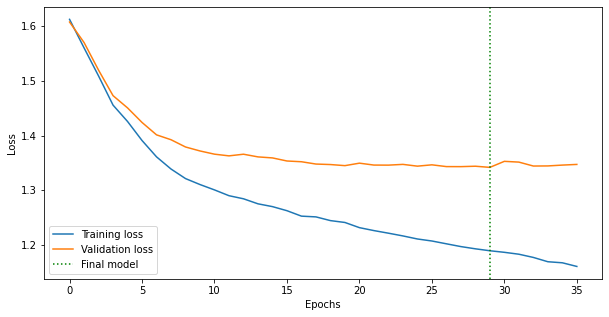

In [25]:
plt.figure(figsize=(10,5))
plt.plot(final_model.train_losses, label="Training loss")
plt.plot(final_model.val_losses, label="Validation loss")
plt.axvline(final_model.val_losses.argmin(), linestyle='dotted', color='g',label='Final model')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig(os.path.join(model_path, "losses.png"))

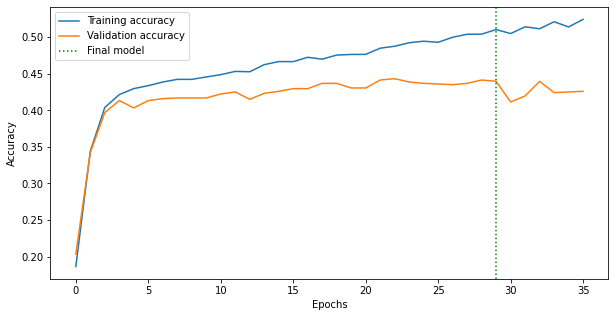

In [26]:
plt.figure(figsize=(10,5))
plt.plot(final_model.train_accs, label="Training accuracy")
plt.plot(final_model.val_accs, label="Validation accuracy")
plt.axvline(final_model.val_losses.argmin(), linestyle='dotted', color='g',label='Final model')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(os.path.join(model_path, "accs.png"))

## 1.5 Final accuracies

In [28]:
# Obtain best epoch accuracies and add a newly obtained test set value.
test_acc, _ = eval_model(best_model, test_iter, criterion)

print("Training Accuracy: {:.2%}".format(best_model.train_accs[best_model.val_accs.argmax()]))
print("Validation Accuracy: {:.2%}".format(best_model.val_accs.max()))
print("Test Accuracy: {:.2%}".format(test_acc))

Training Accuracy: 48.76%
Validation Accuracy: 44.32%
Test Accuracy: 43.26%


## 1.6 New sentences classification

In [166]:
# Reviews source: https://www.rottentomatoes.com/m/a_quiet_place_2018/reviews?type=user

reviews = [
    "Very well done , from acting to cinematography all first rate.",
    "I have seen a lot of terrible movies in my life and this was the worst by far!",
    "As far as horror movies go, this is one of the only ones in my life that I felt I wasted my time that I won't get back.",
    "Cheap move using Deaf culture as the only interesting feature.",
    "honestly amazing, i was literally holding my breath through out the movie, Emily Blunt and John Krasinski were brilliant the whole way.",
]

field = [('Text', TEXT)]

with open("./data/examples.csv", "w") as f:
    csv.writer(f).writerows([[r] for r in reviews])
    
example_data = tt.data.TabularDataset(path='./data/examples.csv', 
                format='csv', fields=field)

example_iter = tt.data.Iterator(example_data, batch_size=1, device=device, shuffle=False)

best_model.eval()
pred_idxs = []
with torch.no_grad():
    for inputs, _ in example_iter:
        outputs = best_model(inputs).squeeze()
        pred_idxs_tensor = outputs.argmax(axis=-1)
        pred_idxs.append(pred_idxs_tensor.item())

for i in range(len(pred_idxs)):
    print("Review {} - Predicted Rating: {}:\n  {}".format(i, pred_idxs[i], reviews[i]))

Review 0 - Predicted Rating: 3:
  Very well done , from acting to cinematography all first rate.
Review 1 - Predicted Rating: 4:
  I have seen a lot of terrible movies in my life and this was the worst by far!
Review 2 - Predicted Rating: 4:
  As far as horror movies go, this is one of the only ones in my life that I felt I wasted my time that I won't get back.
Review 3 - Predicted Rating: 0:
  Cheap move using Deaf culture as the only interesting feature.
Review 4 - Predicted Rating: 3:
  honestly amazing, i was literally holding my breath through out the movie, Emily Blunt and John Krasinski were brilliant the whole way.
